# Работа с датасетом

In [52]:
#загрузка используемых библиотек
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [53]:
#выгрузка датасета в среду
df=pd.read_excel('anketa.xlsx')

In [54]:
#редактура датасета, его очистка от невалидных значений, создание вспомогательных словарей
def create_dict_from_df(df):
    dictionary = {}
    for column in df.columns:
        dictionary[column] = df[column].iloc[0]
    return dictionary

list_levels={'уровень_о':'Выраженность одиночества', 'уровень_а':'Выраженность аномии', 
             'уровень_и':'Выраженность интегрированности в субкультуру', 'уровень_р':'Выраженность эффекта расторможенности'}

question_dict=create_dict_from_df(df)

df.drop(index=0, inplace=True)

df = df[df['Q1'] != -1]

column_names = df.columns.tolist()

df = df.replace([-1, -3], pd.NA)

df = df.dropna()

df = df.replace([6], pd.NA)

df['Q3'].replace({-2: 1}, inplace=True)

df['Q8_2'] = np.where(df['Q8_2'] < 0, np.nan, df['Q8_2'])
mean_value=df['Q8_2'].mean()
df['Q8_2'].fillna(mean_value, inplace=True)

In [55]:
#создание интервальных и порядковых шкал для измерения выраженности концептов
lonely_columns=['Q5a', 'Q5b', 'Q5c', 'Q5d', 'Q5e', 'Q5f', 'Q5g', 
                'Q6a', 'Q6b', 'Q6c', 'Q6d', 'Q6e', 'Q6f', 
                'Q7a', 'Q7b', 'Q7c', 'Q7d', 'Q7e', 'Q7f']

lonely_table=df[lonely_columns]
df['loneliness']=df[lonely_columns].sum(axis=1)
df['max_l']=df[lonely_columns].notna().sum(axis=1)*5
df = df.drop(df[df['max_l'] == 0].index)


anomie_columns=['Q8a', 'Q8b', 'Q8c', 'Q8d', 'Q8e', 'Q8f', 'Q8g', 
                'Q9a', 'Q9b', 'Q9c', 'Q9d', 'Q9e', 'Q9f', 'Q9g',
                'Q10a', 'Q10b', 'Q10c', 'Q10d', 'Q10e', 'Q10f', 'Q10g', 'Q10h']

anomie_table=df[anomie_columns]
df['anomie']=df[anomie_columns].sum(axis=1)
df['max_a']=df[anomie_columns].notna().sum(axis=1)*5


integr_columns=['Q11d', 'Q11e', 'Q11f', 'Q11g', 
                'Q12b', 'Q12c', 'Q12d', 'Q12e', 'Q12f', 'Q13']

integr_table=df[integr_columns]
df['integr']=df[integr_columns].sum(axis=1)
df['max_i']=df[integr_columns].notna().sum(axis=1)*5


rast_columns=['Q11a', 'Q11b', 'Q11c', 'Q12a']

rast_table=df[rast_columns]
df['rast']=df[rast_columns].sum(axis=1)
df['max_r']=df[rast_columns].notna().sum(axis=1)*5

In [56]:
#создание интервальных и порядковых шкал оценки уровней выраженности индикаторов и переименовка части столбцов
df['одиночество']=round(df['loneliness']*100/df['max_l'], 2)
df['аномия']=round(df['anomie']*100/df['max_a'], 2)
df['интегрированность']=round(df['integr']*100/df['max_i'], 2)
df['расторможенность']=round(df['rast']*100/df['max_r'], 2)

levels_dict={1:(0, 35/0.8),
             2:(35/0.8, 50/0.8),
             3:(50/0.8, 65/0.8),
             4:(65/0.8, 81/0.8)}
levels_words={1:'низкий', 2:'средний', 3:'средне-высокий', 4:'высокий'}


df['уровень_о']=df['одиночество'].apply(lambda x: next((name for name, (start, end) in levels_dict.items() if start<=x<end), None))
df['уровень_а']=df['аномия'].apply(lambda x: next((name for name, (start, end) in levels_dict.items() if start<=x<end), None))
df['уровень_и']=df['интегрированность'].apply(lambda x: next((name for name, (start, end) in levels_dict.items() if start<=x<end), None))
df['уровень_р']=df['расторможенность'].apply(lambda x: next((name for name, (start, end) in levels_dict.items() if start<=x<end), None))

df['Возрастная_группа'] = pd.cut(df['Q8_2'], bins=[0, 17, 25, float('inf')], labels=['младше 18 лет', '18-25 лет', 'старше 25 лет'])

df.rename(columns={'Q1': 'Пол'}, inplace=True) 
df['Пол'] = df['Пол'].replace({1: 'мужчина', 2: 'женщина'})

df.rename(columns={'Q3': 'Ром_отношения'}, inplace=True) 
df['Ром_отношения'] = df['Ром_отношения'].replace({1: 'состою', 2: 'не состою'})

df.rename(columns={'Q4': 'Хар_проживания'}, inplace=True) 
df['Хар_проживания'] = df['Хар_проживания'].replace({1: 'Живу один', 2: 'Живу с родителями и/или другими родственниками',
                                                    3: 'Живу с партнером', 4: 'Живу с друзьями', 5: 'Живу в общежитии'})

df.rename(columns={'Q8_2': 'Возраст'}, inplace=True) 

In [57]:
#вид колонок датасета
columns_to_display = ['Пол', 'Возраст', 'Ром_отношения', 'Хар_проживания',
                     'одиночество', 'аномия', 'интегрированность', 'расторможенность', 
                      'уровень_о', 'уровень_а', 'уровень_и', 'уровень_р', 'Возрастная_группа']

df[columns_to_display]

,Пол,Возраст,Ром_отношения,Хар_проживания,одиночество,аномия,интегрированность,расторможенность,уровень_о,уровень_а,уровень_и,уровень_р,Возрастная_группа
1,мужчина,20.0,состою,Живу в общежитии,35.79,53.64,58.00,70.0,1,2,2,3,18-25 лет
2,женщина,18.0,состою,Живу в общежитии,64.21,61.00,70.00,50.0,3,2,3,2,18-25 лет
3,мужчина,20.0,не состою,Живу один,66.32,65.45,32.50,60.0,3,3,1,2,18-25 лет
4,мужчина,20.0,не состою,Живу с родителями и/или другими родственниками,53.68,70.00,42.00,65.0,2,3,1,3,18-25 лет
5,мужчина,19.0,состою,Живу с родителями и/или другими родственниками,64.21,69.09,66.00,65.0,3,3,3,3,18-25 лет
...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,мужчина,35.0,не состою,Живу один,53.68,40.00,57.78,70.0,2,1,2,3,старше 25 лет
620,мужчина,42.0,состою,Живу с партнером,55.79,74.55,66.00,90.0,2,3,3,4,старше 25 лет
621,женщина,19.0,состою,Живу в общежитии,78.95,69.09,74.00,35.0,3,3,3,1,18-25 лет
622,мужчина,16.0,не состою,Живу с родителями и/или другими родственниками,74.74,70.00,78.00,85.0,3,3,3,4,младше 18 лет


# Тесты

In [58]:
#введение функций
def shapiro(a):
    '''тест Шапиро'''
    return f'{a.name.capitalize()}, p-value: {stats.shapiro(a)[1]}'

def mediana(a):
    '''нахождение медианы'''
    return f', медиана: {a.median()}'

def variation(a):
    '''коэффициент качественной вариации'''
    kkv= 1 - sum(math.pow(p, 2) for p in a.value_counts(normalize=True))
    return f'Коэффициент качественной вариации {a.name.capitalize()}: {kkv}'

def manwhit(n, a, b):
    '''тест Манна-Уитни'''
    s, p = stats.mannwhitneyu(a, b)
    return f'{n}, p-value: {p}, статистика: {s}'

def kruswal(n, a):
    '''тест Краскела-Уолисса'''
    s, p = stats.kruskal(*a)
    return f'{n}, p-value: {p}, статистика: {s}'

def sperm(a, b):
    '''коэффициент корреляции Спирмена'''
    c, p = stats.spearmanr(a, b)
    return f'{a.name.capitalize()}, {b.name.capitalize()}, p-value: {p}, значение корреляции: {c}'

def pagan(rez):
    '''тест Бройша-Пагана'''
    return f'P-value регрессионной модели: {sm.stats.diagnostic.het_breuschpagan(rez.resid, rez.model.exog)[1]}'

In [8]:
#проверка на нормальность распределения
for i in ['одиночество', 'аномия', 'интегрированность', 'расторможенность']:
    print(shapiro(df[i]))

Одиночество, p-value: 6.635351746808738e-05
Аномия, p-value: 0.49864301085472107
Интегрированность, p-value: 0.00015338504454120994
Расторможенность, p-value: 1.5234825900822813e-10


In [9]:
#извлечение медиан
for i in ['одиночество', 'аномия', 'интегрированность', 'расторможенность']:
    print(i+mediana(df[i]))
print('')
s=0
for i in [[df[df['Пол']=='мужчина']['одиночество'], df[df['Пол']=='женщина']['одиночество']],
         [df[df['Ром_отношения']=='состою']['одиночество'], df[df['Ром_отношения']=='не состою']['одиночество']],
         [df['одиночество'][df['Хар_проживания'] == 'Живу один'],
                            df['одиночество'][df['Хар_проживания'] == 'Живу с родителями и/или другими родственниками'],
                            df['одиночество'][df['Хар_проживания'] == 'Живу с партнером'],
                            df['одиночество'][df['Хар_проживания'] == 'Живу с друзьями'],
                            df['одиночество'][df['Хар_проживания'] == 'Живу в общежитии']]]:
    s+=1
    print('')
    for j in i:
        print(str(s)+mediana(j))
print('')    
print('Q12f'+mediana(df['Q12f']))

одиночество, медиана: 60.0
аномия, медиана: 62.0
интегрированность, медиана: 64.0
расторможенность, медиана: 70.0


1, медиана: 59.475
1, медиана: 63.355

2, медиана: 43.155
2, медиана: 62.83

3, медиана: 57.89
3, медиана: 63.16
3, медиана: 41.05
3, медиана: 53.68
3, медиана: 59.475

Q12f, медиана: 2.0


In [10]:
#коэффициент качественной вариации
for i in ['уровень_о', 'уровень_а', 'уровень_и', 'уровень_р', 'Q12f']:
    print(variation(df[i]))

Rоэффициент качественной вариации Уровень_о: 0.7279368187791492
Rоэффициент качественной вариации Уровень_а: 0.652335798397279
Rоэффициент качественной вариации Уровень_и: 0.7282460254064779
Rоэффициент качественной вариации Уровень_р: 0.7371485995516504
Rоэффициент качественной вариации Q12f: 0.7788311566963035


In [11]:
#тест Манна-Уитни
s=0
for i in [[df[df['Пол']=='мужчина']['одиночество'], df[df['Пол']=='женщина']['одиночество']], 
          [df[df['Ром_отношения']=='состою']['одиночество'], df[df['Ром_отношения']=='не состою']['одиночество']]]:
    s+=1
    j,k=i
    print(manwhit(s, j, k))

1, p-value: 0.1014741570263494, статистика: 5961.5
2, p-value: 2.483510386391498e-10, статистика: 7840.5


In [12]:
#тест Краскела-Уолисса
s=0
for i in [[df[df['Q12f']==1]['одиночество'], df[df['Q12f']==2]['одиночество'], df[df['Q12f']==3]['одиночество'], 
              df[df['Q12f']==4]['одиночество'], df[df['Q12f']==5]['одиночество']],
        [df[df['Возрастная_группа']=='младше 18 лет']['одиночество'], df[df['Возрастная_группа']=='18-25 лет']['одиночество'], 
       df[df['Возрастная_группа']=='старше 25 лет']['одиночество']],
         [df['одиночество'][df['Хар_проживания'] == 'Живу один'],
                            df['одиночество'][df['Хар_проживания'] == 'Живу с родителями и/или другими родственниками'],
                            df['одиночество'][df['Хар_проживания'] == 'Живу с партнером'],
                            df['одиночество'][df['Хар_проживания'] == 'Живу с друзьями'],
                            df['одиночество'][df['Хар_проживания'] == 'Живу в общежитии']]]:
    s+=1
    print(kruswal(s, i))

1, p-value: 1.532083280678163e-10, статистика: 51.78202940857891
2, p-value: 0.17649752107721298, статистика: 3.4688968951914556
3, p-value: 4.6692208533982806e-05, статистика: 25.16114721694289


In [13]:
#метод Тьюки
posthoc = pairwise_tukeyhsd(df['одиночество'], df['Хар_проживания'], alpha=0.05/5)
print(posthoc.summary())

                          Multiple Comparison of Means - Tukey HSD, FWER=0.01                          
     group1                          group2                     meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------------------------------------
Живу в общежитии                                      Живу один   0.3048    0.9 -11.7262 12.3357  False
Живу в общежитии                                Живу с друзьями  -2.4224    0.9 -23.2457 18.4009  False
Живу в общежитии                               Живу с партнером  -10.874 0.0659 -24.3895  2.6415  False
Живу в общежитии Живу с родителями и/или другими родственниками   4.1924 0.7031  -6.9088 15.2936  False
       Живу один                                Живу с друзьями  -2.7272    0.9 -21.8679 16.4135  False
       Живу один                               Живу с партнером -11.1788 0.0064 -21.9225 -0.4351   True
       Живу один Живу с родителями и/или другими родственниками 

In [14]:
#коэффициент корреляции Спирмена
for i in [[df['Возраст'],df['одиночество']],
          [df['аномия'], df['одиночество']],
          [df['интегрированность'], df['одиночество']]]:
    j, k = i
    print(sperm(j, k))

Возраст, Одиночество, p-value: 0.01752362003895978, значение корреляции: -0.11962765157250814
Аномия, Одиночество, p-value: 2.519424118403475e-36, значение корреляции: 0.5768518894945805
Интегрированность, Одиночество, p-value: 2.7460618299785237e-13, значение корреляции: 0.35701972456664677


In [15]:
#линейная регрессия
df_filled = df.fillna(df.mean())
df_filled['Константа'] = 1
X = df_filled[['Q13','Q11d', 'Q12b', 'Q12e', 'Q12c', 'Q11e', 'Константа']]
y = df_filled['одиночество']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

2023-07-02 21:02:53,551 [22324] WARNING  py.warnings:109: [JupyterRequire] C:\Users\urasl\AppData\Local\Temp/ipykernel_22324/457679585.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_filled = df.fillna(df.mean())



                            OLS Regression Results                            
Dep. Variable:            одиночество   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     7.242
Date:                Sun, 02 Jul 2023   Prob (F-statistic):           2.42e-07
Time:                        21:02:53   Log-Likelihood:                -1694.3
No. Observations:                 394   AIC:                             3403.
Df Residuals:                     387   BIC:                             3431.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Q13           -1.5473      0.818     -1.891      0.0

In [16]:
# Создание матрицы корреляции
predictors = model.exog
correlation_matrix = pd.DataFrame(predictors).corr()
print(correlation_matrix)

          0         1         2         3         4         5   6
0  1.000000  0.301740  0.215836  0.062215  0.444676  0.294912 NaN
1  0.301740  1.000000  0.357480  0.343412  0.452794  0.589278 NaN
2  0.215836  0.357480  1.000000  0.292061  0.302369  0.410846 NaN
3  0.062215  0.343412  0.292061  1.000000  0.254391  0.518769 NaN
4  0.444676  0.452794  0.302369  0.254391  1.000000  0.419746 NaN
5  0.294912  0.589278  0.410846  0.518769  0.419746  1.000000 NaN
6       NaN       NaN       NaN       NaN       NaN       NaN NaN


In [17]:
#тест Бройша-Пагана
print(pagan(results))

P-value регрессионной модели: 0.535032568600518


In [18]:
lorder1=['низкий','средний','средне-высокий','высокий']
lorder2=['младше 18 лет', '18-25 лет', 'старше 25 лет']
lorder3=[1,2,3,4,5]

# Визуализация

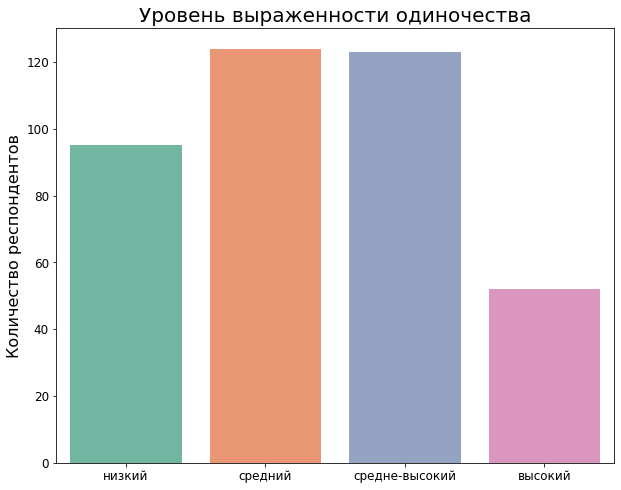

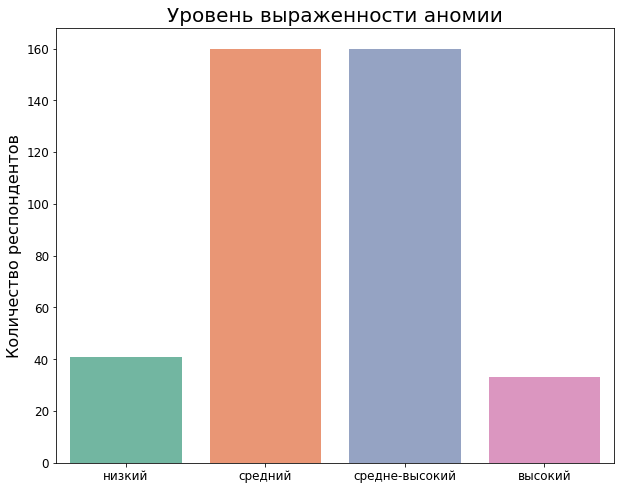

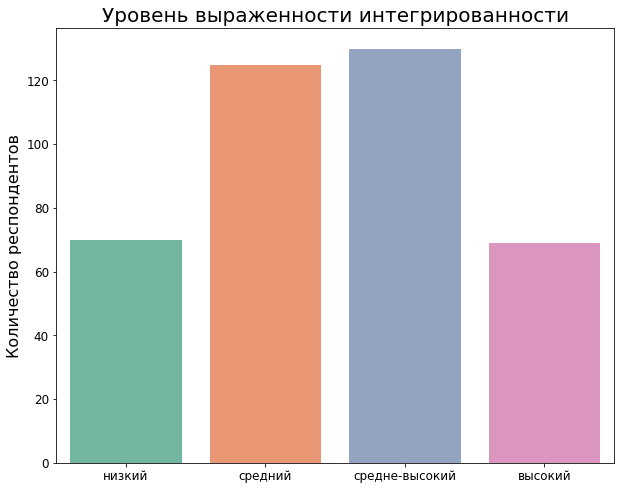

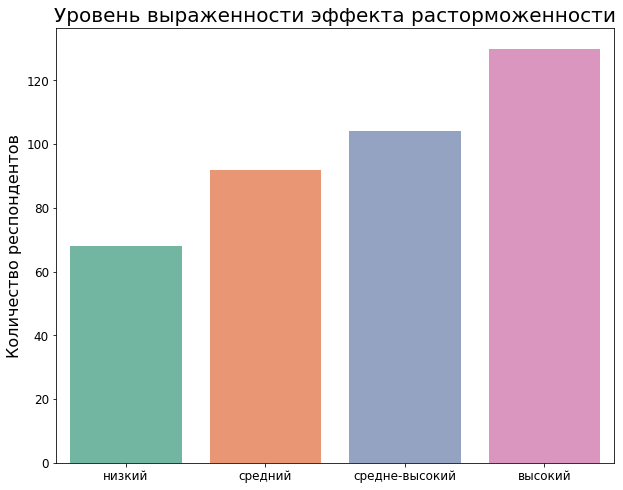

In [19]:
#графики категориальных распределений
chastota= df['уровень_о'].value_counts()
plt.figure(figsize=(10, 8))
sns.barplot(x=chastota.index.map(levels_words), y=chastota.values, data=chastota, order=lorder1, palette='Set2')
#plt.xlabel('Уровень выраженности')
plt.ylabel('Количество респондентов', fontsize=16)
plt.title('Уровень выраженности одиночества', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

chastota= df['уровень_а'].value_counts()
plt.figure(figsize=(10, 8))
sns.barplot(x=chastota.index.map(levels_words), y=chastota.values, data=chastota, order=lorder1, palette='Set2')
#plt.xlabel('Уровень выраженности')
plt.ylabel('Количество респондентов', fontsize=16)
plt.title('Уровень выраженности аномии', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

chastota= df['уровень_и'].value_counts()
plt.figure(figsize=(10, 8))
sns.barplot(x=chastota.index.map(levels_words), y=chastota.values, data=chastota, order=lorder1, palette='Set2')
#plt.xlabel('Уровень выраженности')
plt.ylabel('Количество респондентов', fontsize=16)
plt.title('Уровень выраженности интегрированности', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

chastota= df['уровень_р'].value_counts()
plt.figure(figsize=(10, 8))
sns.barplot(x=chastota.index.map(levels_words), y=chastota.values, data=chastota, order=lorder1, palette='Set2')
#plt.xlabel('Уровень выраженности')
plt.ylabel('Количество респондентов', fontsize=16)
plt.title('Уровень выраженности эффекта расторможенности', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()




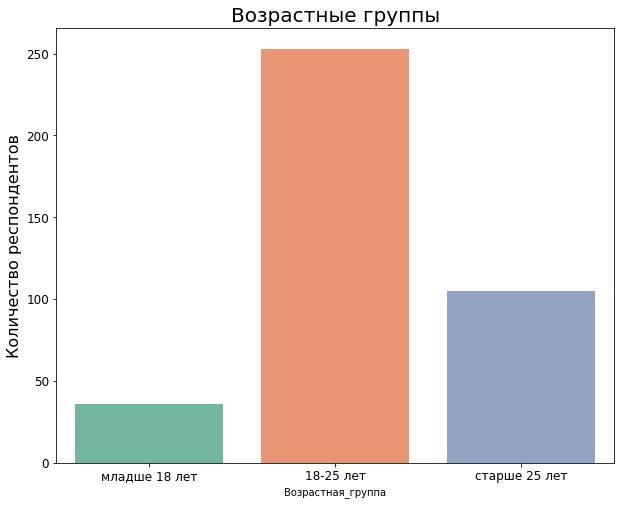

In [20]:
plt.figure(figsize=(10, 8))
sns.countplot(x='Возрастная_группа', data=df, order=lorder2, palette='Set2')
#plt.xlabel('Уровень выраженности')
plt.ylabel('Количество респондентов', fontsize=16)
plt.title('Возрастные группы', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

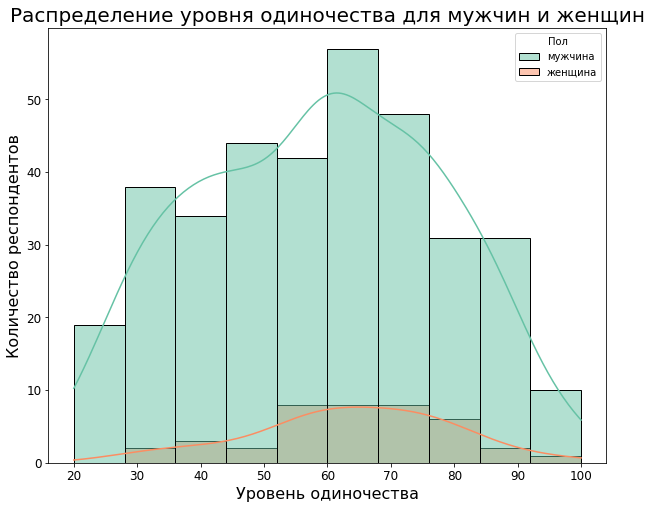

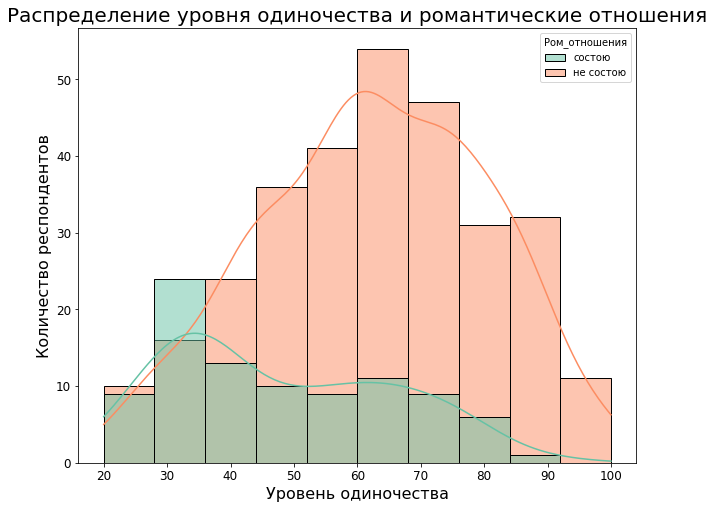

In [21]:
plt.figure(figsize=(10, 8))
sns.histplot(data=df, x='одиночество', hue='Пол', kde=True, palette='Set2')
plt.xlabel('Уровень одиночества', fontsize=16)
plt.ylabel('Количество респондентов', fontsize=16)
plt.title('Распределение уровня одиночества для мужчин и женщин', fontsize=20)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(10, 8))
sns.histplot(data=df, x='одиночество', hue='Ром_отношения', kde=True, palette='Set2')
plt.xlabel('Уровень одиночества', fontsize=16)
plt.ylabel('Количество респондентов', fontsize=16)
plt.title('Распределение уровня одиночества и романтические отношения', fontsize=20)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

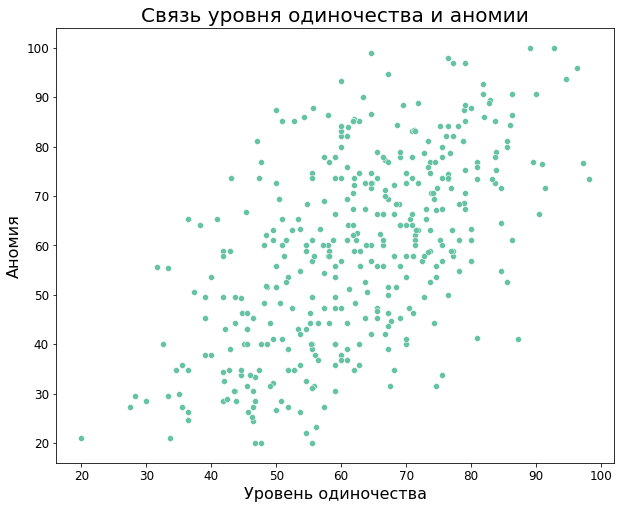

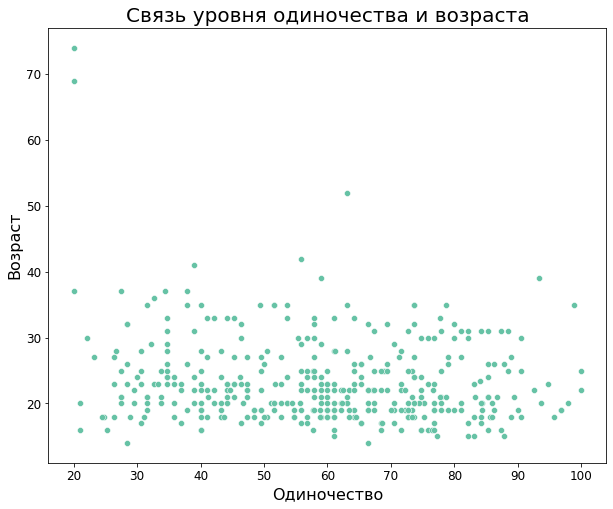

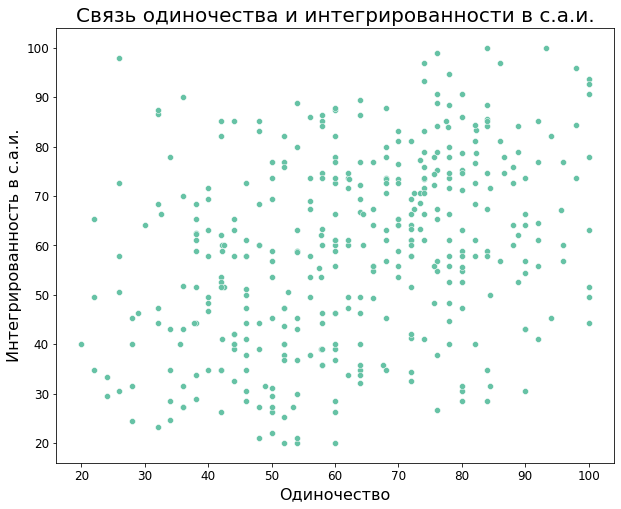

In [22]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df['аномия'], y=df['одиночество'], data=df, color=sns.color_palette("Set2")[0])
plt.xlabel('Уровень одиночества',fontsize=16)
plt.ylabel('Аномия',fontsize=16)
plt.title('Связь уровня одиночества и аномии',fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(x=df['одиночество'], y=df['Возраст'], data=df, color=sns.color_palette("Set2")[0])
plt.xlabel('Одиночество',fontsize=16)
plt.ylabel('Возраст',fontsize=16)
plt.title('Связь уровня одиночества и возраста',fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(x=df['интегрированность'], y=df['одиночество'], data=df, color=sns.color_palette("Set2")[0])
plt.xlabel('Одиночество',fontsize=16)
plt.ylabel('Интегрированность в с.а.и.',fontsize=16)
plt.title('Связь одиночества и интегрированности в с.а.и.',fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

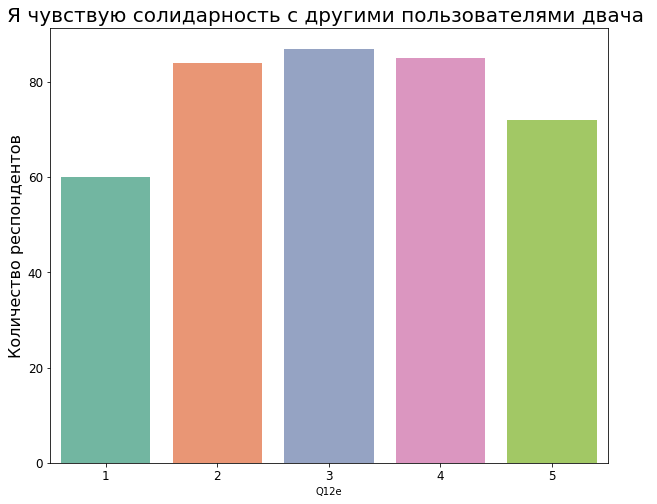

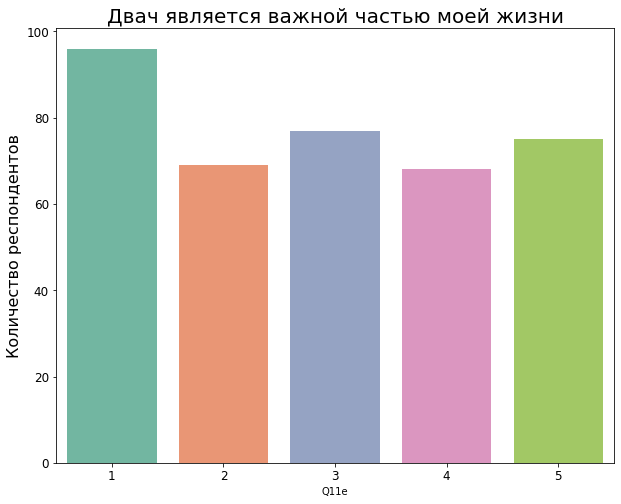

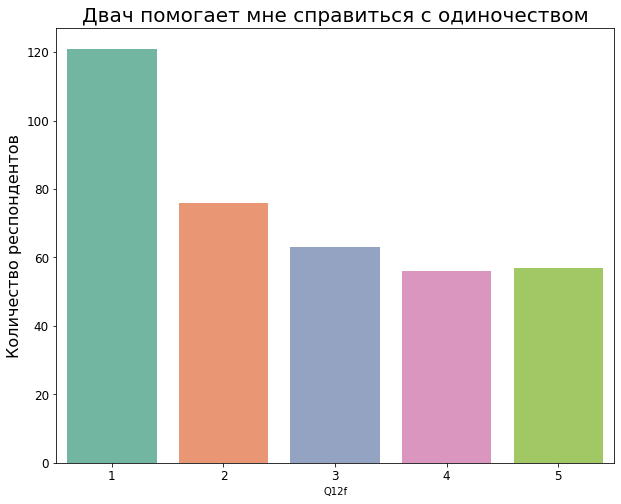

In [23]:
plt.figure(figsize=(10, 8))
sns.countplot(x='Q12e', data=df, order=lorder3, palette='Set2')
#plt.xlabel('Уровень выраженности')
plt.ylabel('Количество респондентов', fontsize=16)
plt.title(question_dict['Q12e'], fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(10, 8))
sns.countplot(x='Q11e', data=df, order=lorder3, palette='Set2')
#plt.xlabel('Уровень выраженности')
plt.ylabel('Количество респондентов', fontsize=16)
plt.title(question_dict['Q11e'], fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(10, 8))
sns.countplot(x='Q12f', data=df, order=lorder3, palette='Set2')
#plt.xlabel('Уровень выраженности')
plt.ylabel('Количество респондентов', fontsize=16)
plt.title(question_dict['Q12f'], fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()